# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [ ]:
import os
import re
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [94]:
# Add any additional import statements you need here
from nltk.tokenize import word_tokenize
import seaborn as sns


In [6]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/mtc/ADS/ADS 509/M1 Results"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "/Users/mtc/ADS/ADS 509/ads509_assignment6/positive-words.txt"
negative_words_file = "/Users/mtc/ADS/ADS 509/ads509_assignment6/negative-words.txt"
tidy_text_file = "/Users/mtc/ADS/ADS 509/ads509_assignment6/tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [3]:
# Read in the lyrics data

lyric_df = []

for artist in os.listdir(os.path.join(data_location,lyrics_folder)):
    path = os.path.join(data_location,lyrics_folder, artist)

    for file in os.listdir(path):

        song_path = path + '/' + file

        with open(song_path, 'r', encoding='utf-8') as s:
            lyrics = s.read()
            title = str(re.findall(r'".+"', lyrics))
            title = title[3:-3]
            lyrics_c = re.sub('^".+"', '', lyrics)
            lyric_df.append({
                'artist' :artist,
                'song_title': title,
                'lyrics': lyrics_c
            })
lyric_df = pd.DataFrame(lyric_df)

In [4]:
# Read in the twitter data
twitter_df= []

for artist in os.listdir(os.path.join(data_location,twitter_folder)):
    path = os.path.join(data_location,twitter_folder)

    for file in os.listdir(path):
        file_skip_sub = '_followers.txt'

        if file.endswith(file_skip_sub):
            continue

        twitter_path = os.path.join(data_location, twitter_folder, file)

        temp_df = pd.read_csv(twitter_path, sep='\t', encoding='utf-8', on_bad_lines='skip')

        artist = re.sub('_followers_data.txt', '', file)

        desc = temp_df['description']

        for i in range(len(temp_df)):
            twitter_df.append({
                'artist': artist,
                'description': str(desc.iloc[i])
            })
twitter_df = pd.DataFrame(twitter_df)
twitter_df = twitter_df[twitter_df['description']!= 'nan']

In [63]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.
positive_words = pd.read_csv(positive_words_file, skiprows=34,  header=None).set_axis(['word'], axis = 1)
positive_words['value'] = 1
positive_dict = dict(zip(positive_words['word'], positive_words['value']))

negative_words = pd.read_csv(negative_words_file, skiprows=34,  header=None).set_axis(['word'], axis = 1)
negative_words['value'] = -1
negative_dict = dict(zip(negative_words['word'], positive_words['value']))

tidy_text = pd.read_csv(tidy_text_file, sep='\t',)
tidy_text['value'] = tidy_text['sentiment'].apply(lambda x: -1 if x == 'negative' else 1)
tidy_text_dict = dict(zip(tidy_text['word'], tidy_text['value']))

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [ ]:
# your code here
# pulled from textbook chapter 11 and adapted

def lexicon_sentiment(text):
    sentiment_score = 0
    bag_of_words = word_tokenize(text.lower())
    for word in bag_of_words:
        if word in tidy_text_dict:
            sentiment_score += tidy_text_dict[word]
    return sentiment_score / len(bag_of_words)

lyric_df['sentiment'] = lyric_df['lyrics'].apply(lexicon_sentiment)

### Question 1

Q: Overall, which artist has the higher average sentiment per song? 

A: Overall, Robyn has a higher average sentiment rating per song.

In [97]:
lyric_df.groupby('artist')['sentiment'].mean()

artist
cher     0.026609
robyn    0.029852
Name: sentiment, dtype: float64


### Question 2 

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: 

Robyn Highest Sentiments: Baby Forgive Me, Love is Free, We Dance to the Beat

These three songs include words such as "dance", "love", "free", and "forgive", which could be taken as positive words.

Robyn Lowest Sentiments: Don't Fucking Tell Me What To Do, Criminal Intent, Robotboy.

These songs have a lot of the words "killing", "criminal", "crash" and "low", which definitely come across as negative.

In [127]:
r_top = list(lyric_df[lyric_df['artist'] == 'robyn'].nlargest(3, 'sentiment').lyrics)
r_bot = list(lyric_df[lyric_df['artist'] == 'robyn'].nsmallest(4, 'sentiment').lyrics) #pulled 4 because one song was repeated

print(r_top[0])
print(r_top[1])
print(r_top[2])





Here come the night
In your eyes
Baby, be brave
Be wise
It's up to you
You do what you like, mmm
Won't you give it a chance, baby?
Just one more try

Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me

(Won't you give it a chance, baby?)
Won't you give it a chance, baby?
Just one more try
One more try
Yeah, eh

You got the power
You set the price
But baby, be fair
Be nice
You say you want to be happy
Then you got to put your love on the line
Just let me make you smile again, baby
I know we can work it out
Yes, I know we can

Baby forgive me
Yeah
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me





Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, ba

In [128]:
print(r_bot[0])
print(r_bot[2])
print(r_bot[3])





My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me

My smoking is killing me
My diet is killing me
My heels are killing me
My shopping's killing me
My ego is killing me
Can't sleep, it's killing me
My label's killing me
Kickdrum

My phone is killing me
My email is killing me
These hours are killing me
My tour is killing me
This flight is killing me
My manager's killing me
My mother's killing me
My landlord's killing me
My boss is killing me
The TV is killing me
Your nagging is killing me
My boyfriend's killing me
My talking's killing me
Killing me
Killing me

Can't sleep, it's killing me
My dreams are killing me
TV is killing me
My talking's killing

### Question 3

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: 

Cher Highest Sentiments: My Love Goodbye, Sunny, Love and Understanding

These songs have a lot of the word "love", "thank you", "enough", and "understanding". These come across as quite positive, since they often come up in a positive context.

Cher Lowest Sentiments: Bang Bang, Bang Bang (My Baby Shot Me Down), Girl Don't Come

The words "don't", "tears", "shot", and "hurt" show up in the songs with the lowest sentiments, which makes sense. These words mostly show up in a very negative context.

In [129]:
c_top = list(lyric_df[lyric_df['artist'] == 'cher'].nlargest(3, 'sentiment').lyrics)
c_bot = list(lyric_df[lyric_df['artist'] == 'cher'].nsmallest(3, 'sentiment').lyrics)

print(c_top[0])
print(c_top[1])
print(c_top[2])





When I go away
I know my heart can stay with my love
It's understood
Everywhere with my love
My love does it good, whoa
My love, oh only my love
My love does it good

And when the cupboard's bare
I'll still find something there with my love
It's understood
Everywhere with my love
My love does it so good, whoa
My love, oh only my love
My love does it good

Only my love, oh only my love
Only my love, hold the other things to me
Oh, only my love, oh only my love
Only my love does it good to me

Everywhere with my love
Don't you see my love
It does it so good
Oh, only my love, only my love
My love does it good

Don't ever ask me why
I never say "good-bye" to my love
It's understood
'Cause everywhere with my love
My love does it good, whoa
Only my love, oh only my love
My love does it good

Oh only my love
Only my love does it good to me,whoa





Sunny, yesterday my life was filled with rain
Sunny, you smiled at me and then it eased my pain
Now the dark days are gone and bright days ar

In [130]:
print(c_bot[0])
print(c_bot[1])
print(c_bot[2])





Bang bang you shot me down
Bang bang I hit the ground
Bang bang that awful sound
Bang bang my baby shot me down

I was five and you were six
We rode on horses made of sticks
I wore black you wore white
You would always win the fight

Bang bang you shot me down
Bang bang I hit the ground
Bang bang that awful sound
Bang bang my baby shot me down

Seasons came and changed the time
I grew up I called you mine
You would always laugh and say
Remember when we used to play

Bang bang you shot me down
Bang bang and I hit the ground
Bang bang that awful sound
Bang bang my baby shot me down

Music played and people sang
Just for me the church bells rang
After echoes from a gun
We both vowed that we'd be one

Now you're gone I don't know why
Sometimes I cry
You didn't say goodbye
You didn't take the time to lie

Bang bang you shot me down
Bang bang I hit the ground
Bang bang that awful sound
Bang bang my baby shot me down

Bang bang you shot me right between my eyes
Bang bang you can't go para

### Question 4

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

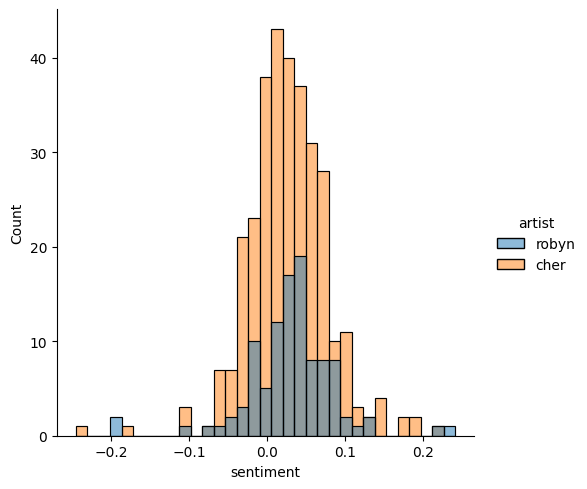

In [95]:
sns.displot(lyric_df, x = 'sentiment', hue='artist')

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [ ]:
# your code here

Q: What is the average sentiment of your two artists? 

A: <!-- Your answer here --> 

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: <!-- Your answer here --> 

